# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_columns', None)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input
The feature file `all_data.csv` is collected from [Jigsaw competition at Kaggle](https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/data?select=all_data.csv)

The result files are collected from the following notebooks
* [Tuning on Jigsaw unintended bias](https://www.kaggle.com/code/khairulislam/tuning-on-jigsaw-unintended-bias)
* [Private tuning on Jigsaw unintended bias](https://www.kaggle.com/code/khairulislam/private-tuning-on-jigsaw-unintended-bias)

In [8]:
data_root = '../../data/'
results_root = '../../results/'


In [12]:
df = pd.read_csv('../../data/all_data.csv')
df.head()

,Unnamed: 0


In [13]:
df.columns

Index(['Unnamed: 0'], dtype='object')

In [6]:
df['labels'] = df['toxicity'] >=0.5

In [7]:
df.groupby(['split'])[['labels']].value_counts()

split  labels
test   False      179193
       True        15448
train  False     1660541
       True       144334
dtype: int64

In [8]:
# other_gender didn't have any example 
genders = ['male', 'female', 'transgender']
# sexual_orientation = ['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']

races = ['black', 'white', 'asian','latino', 'other_race_or_ethnicity']
religions = ['christian', 'jewish', 'muslim', 'hindu','buddhist', 'atheist', 'other_religion']

# ability = ['physical_disability','intellectual_or_learning_disability', 
# 'psychiatric_or_mental_illness','other_disability']

In [9]:
# lr_rate =1e-3,batch_size=128, lr_scheduler
result = pd.read_csv(results_root + 'results.csv')

# lr_rate =1e-3,batch_size=128, max_physical_batch_size=64, lr_scheduler, noise_multiplier=0.2, delta=5e-2
result_dp = pd.read_csv(results_root + 'results_dp.csv')

In [10]:
# result_dp = pd.read_csv('../dp models/1/results_dp_3.csv')
# merged_dp = result_dp.merge(df, on=['id', 'split'], how='inner').reset_index(drop=True)
# merged_dp = convert_dataframe_to_bool(merged_dp)
# test_dp_bias_metrics_df = performance(merged_dp, 'test')

# Preprocess

In [11]:
merged = result.merge(df, on=['id', 'split'], how='inner').reset_index(drop=True)
print(merged.shape)

(483309, 49)


In [12]:
merged_dp = result_dp.merge(df, on=['id', 'split'], how='inner').reset_index(drop=True)
print(merged_dp.shape)

(483309, 49)


In [13]:
subgroup_type='Race'
identity_columns = races

In [14]:
# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['toxicity'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

In [15]:
merged = convert_dataframe_to_bool(merged)
merged_dp = convert_dataframe_to_bool(merged_dp)

In [16]:
merged.groupby(['split'])[['toxicity']].value_counts()

split  toxicity
test   False       179193
       True         15448
train  False       144334
       True        144334
dtype: int64

# Performance

## Metric utils
Implementation is collected from the [Jigsaw competition notebook](https://www.kaggle.com/code/dborkan/benchmark-kernel).
Descriptions are available at the [competition evaluation tab](https://www.kaggle.com/competitions/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation).

In [17]:
from sklearn import metrics

SUBGROUP_F1 = 'subgroup_f1'
SUBGROUP_ACCURACY = 'subgroup_accuracy'
SUBGROUP_AUC = 'subgroup_auc'
SUBGROUP_FPR = 'subgroup_fpr'
SUBGROUP_TPR = 'subgroup_tpr'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive
TOXICITY_COLUMN = 'toxicity'

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

# https://en.wikipedia.org/wiki/False_positive_rate

def calculate_FPR(df, label, model_name):
    y_pred = df[model_name]>=0.5
    false_positives = df[(y_pred) & (~df[label])].shape[0]
    negatives = df[~df[label]].shape[0]

    if negatives == 0:
        print("FPR is undefined. No negative examples found!")
        return np.nan
        
    return false_positives/negatives

def calculate_TPR(df, label, model_name):
    y_pred = df[model_name]>=0.5
    true_positives = df[(y_pred) & (df[label])].shape[0]
    positives = df[df[label]].shape[0]

    if positives == 0:
        print("TPR is undefined. No positive examples found!")
        return np.nan
        
    return true_positives/positives

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset, subgroups, model, label_col):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        subset = dataset[dataset[subgroup]]
        y_true, y_prob, y_pred = subset[label_col], subset[model], subset[model]>=0.5

        record[SUBGROUP_F1] = metrics.f1_score(y_true, y_pred)
        record[SUBGROUP_ACCURACY] = metrics.accuracy_score(y_true, y_pred)
        record[SUBGROUP_AUC] = metrics.roc_auc_score(y_true, y_prob)

        # https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        record[SUBGROUP_FPR] = calculate_FPR(subset, label_col, model)
        record[SUBGROUP_TPR] = calculate_TPR(subset, label_col, model)
        
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records)

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [18]:
def performance(df, split_type='test', prediction_column='probs'):
    df = df[df['split']==split_type]

    bias_metrics_df = compute_bias_metrics_for_model(
        df, identity_columns, prediction_column, TOXICITY_COLUMN
    )
    
    y_preds = df[prediction_column]>=0.5
    acc = metrics.accuracy_score(df[TOXICITY_COLUMN], y_preds)
    f1 = metrics.f1_score(df[TOXICITY_COLUMN], y_preds)
    precision = metrics.precision_score(df[TOXICITY_COLUMN], y_preds)
    recall = metrics.recall_score(df[TOXICITY_COLUMN], y_preds)

    auc = metrics.roc_auc_score(df[TOXICITY_COLUMN], df[prediction_column])

    final_bias = get_final_metric(bias_metrics_df, auc)
    final_fpr = calculate_FPR(df, TOXICITY_COLUMN, prediction_column)
    final_tpr = calculate_TPR(df, TOXICITY_COLUMN, prediction_column)

    TPED = abs(final_tpr - bias_metrics_df[SUBGROUP_TPR]).sum()
    FPED = abs(final_fpr - bias_metrics_df[SUBGROUP_FPR]).sum()

    print(f'Accuracy {np.round(acc, 4)}, AUC {np.round(auc, 4)}, TPR {np.round(final_tpr, 4)}, FPR {np.round(final_fpr, 4)}.')
    print(f'F1 {np.round(f1,4)}, Precision {np.round(precision,4)}, Recall {np.round(recall,4)}')
    print(f'Final bias {np.round(final_bias, 4)}. Eodds {np.round(TPED+FPED, 4)}, TPED {np.round(TPED, 4)}, FPED {np.round(FPED, 4)}.')
    
    return bias_metrics_df

## Normal

### Train

In [19]:
train_bias_metrics_df = performance(merged, 'train')
train_bias_metrics_df

Accuracy 0.8545, AUC 0.9299, TPR 0.8651, FPR 0.1561.
F1 0.856, Precision 0.8471, Recall 0.8651
Final bias 0.8656. Eodds 2.0451, TPED 0.1734, FPED 1.8717.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,black,5538,0.903555,0.832972,0.769584,0.674419,0.926251,0.755297,0.947012
1,white,8586,0.897600,0.825064,0.767887,0.676357,0.935351,0.753926,0.949832
2,asian,911,0.845290,0.803513,0.858842,0.295652,0.863958,0.882218,0.917915
3,latino,534,0.866242,0.803371,0.852351,0.390411,0.876289,0.870518,0.924266
4,other_race_or_ethnicity,121,0.867347,0.785124,0.774494,0.615385,0.894737,0.789570,0.935385


### Test

In [20]:
test_bias_metrics_df = performance(merged, 'test')
test_bias_metrics_df

Accuracy 0.8532, AUC 0.9425, TPR 0.8898, FPR 0.1499.
F1 0.4904, Precision 0.3385, Recall 0.8898
Final bias 0.8856. Eodds 2.3166, TPED 0.4027, FPED 1.9139.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,black,1519,0.544839,0.468729,0.758259,0.774606,0.960239,0.757192,0.956735
1,white,2452,0.515755,0.454731,0.789802,0.764327,0.959569,0.769277,0.960169
2,asian,454,0.410526,0.753304,0.884910,0.257353,0.847826,0.915108,0.923594
3,latino,225,0.596491,0.693333,0.902412,0.396552,1.000000,0.881126,0.955681
4,other_race_or_ethnicity,41,0.466667,0.609756,0.865546,0.470588,1.000000,0.856730,0.956022


## Differential Private

### Train

In [21]:
train_dp_bias_metrics_df = performance(merged_dp, 'train')
train_dp_bias_metrics_df

Accuracy 0.8264, AUC 0.876, TPR 0.8109, FPR 0.1581.
F1 0.8237, Precision 0.8369, Recall 0.8109
Final bias 0.8026. Eodds 1.7593, TPED 0.2221, FPED 1.5372.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,black,5538,0.884767,0.804803,0.671971,0.643023,0.887131,0.648644,0.905458
1,white,8586,0.882095,0.802353,0.687035,0.650517,0.901961,0.649556,0.914587
2,asian,911,0.818588,0.777168,0.811476,0.275362,0.809187,0.820873,0.871499
3,latino,534,0.861979,0.801498,0.781952,0.335616,0.853093,0.775361,0.885655
4,other_race_or_ethnicity,121,0.835165,0.752066,0.749798,0.423077,0.800000,0.763575,0.897707


### Test

In [22]:
test_dp_bias_metrics_df = performance(merged_dp, 'test')
test_dp_bias_metrics_df

Accuracy 0.8533, AUC 0.8934, TPR 0.8356, FPR 0.1451.
F1 0.4749, Precision 0.3317, Recall 0.8356
Final bias 0.8323. Eodds 2.0039, TPED 0.2587, FPED 1.7452.


,subgroup,subgroup_size,subgroup_f1,subgroup_accuracy,subgroup_auc,subgroup_fpr,subgroup_tpr,bpsn_auc,bnsp_auc
0,black,1519,0.532855,0.485188,0.698202,0.713583,0.886680,0.716664,0.905548
1,white,2452,0.522137,0.489396,0.725325,0.698246,0.921833,0.717283,0.927259
2,asian,454,0.406780,0.768722,0.847666,0.232843,0.782609,0.871766,0.875364
3,latino,225,0.552147,0.675556,0.799527,0.385057,0.882353,0.797595,0.917403
4,other_race_or_ethnicity,41,0.428571,0.609756,0.840336,0.441176,0.857143,0.802217,0.879528


# Plot
https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/

In [24]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = False
plt.rcParams["figure.dpi"] = 600

In [25]:
def plot_metric(plot_df, ylabel, subgroup_type='gender',metric='AUC'):
    # plot grouped bar chart
    ax = plot_df.plot(
            x='Identity',
            kind='bar',
            stacked=False,
            # title='Bias (FPR) evaluation on Jigsaw',
            figsize=(14, 6),
            rot=0,
            fontsize=14
    )

    ax.set_xlabel('Identity', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.legend(loc=1, fontsize=12)
    plt.savefig(os.path.join(results_root, f'{subgroup_type}_{metric}_plot.pdf'))

## Count

In [26]:
count_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Train': train_bias_metrics_df['subgroup_size'],
        'Test': test_bias_metrics_df['subgroup_size']
    }
)
count_df

,Identity,Train,Test
0,black,5538,1519
1,white,8586,2452
2,asian,911,454
3,latino,534,225
4,other_race_or_ethnicity,121,41


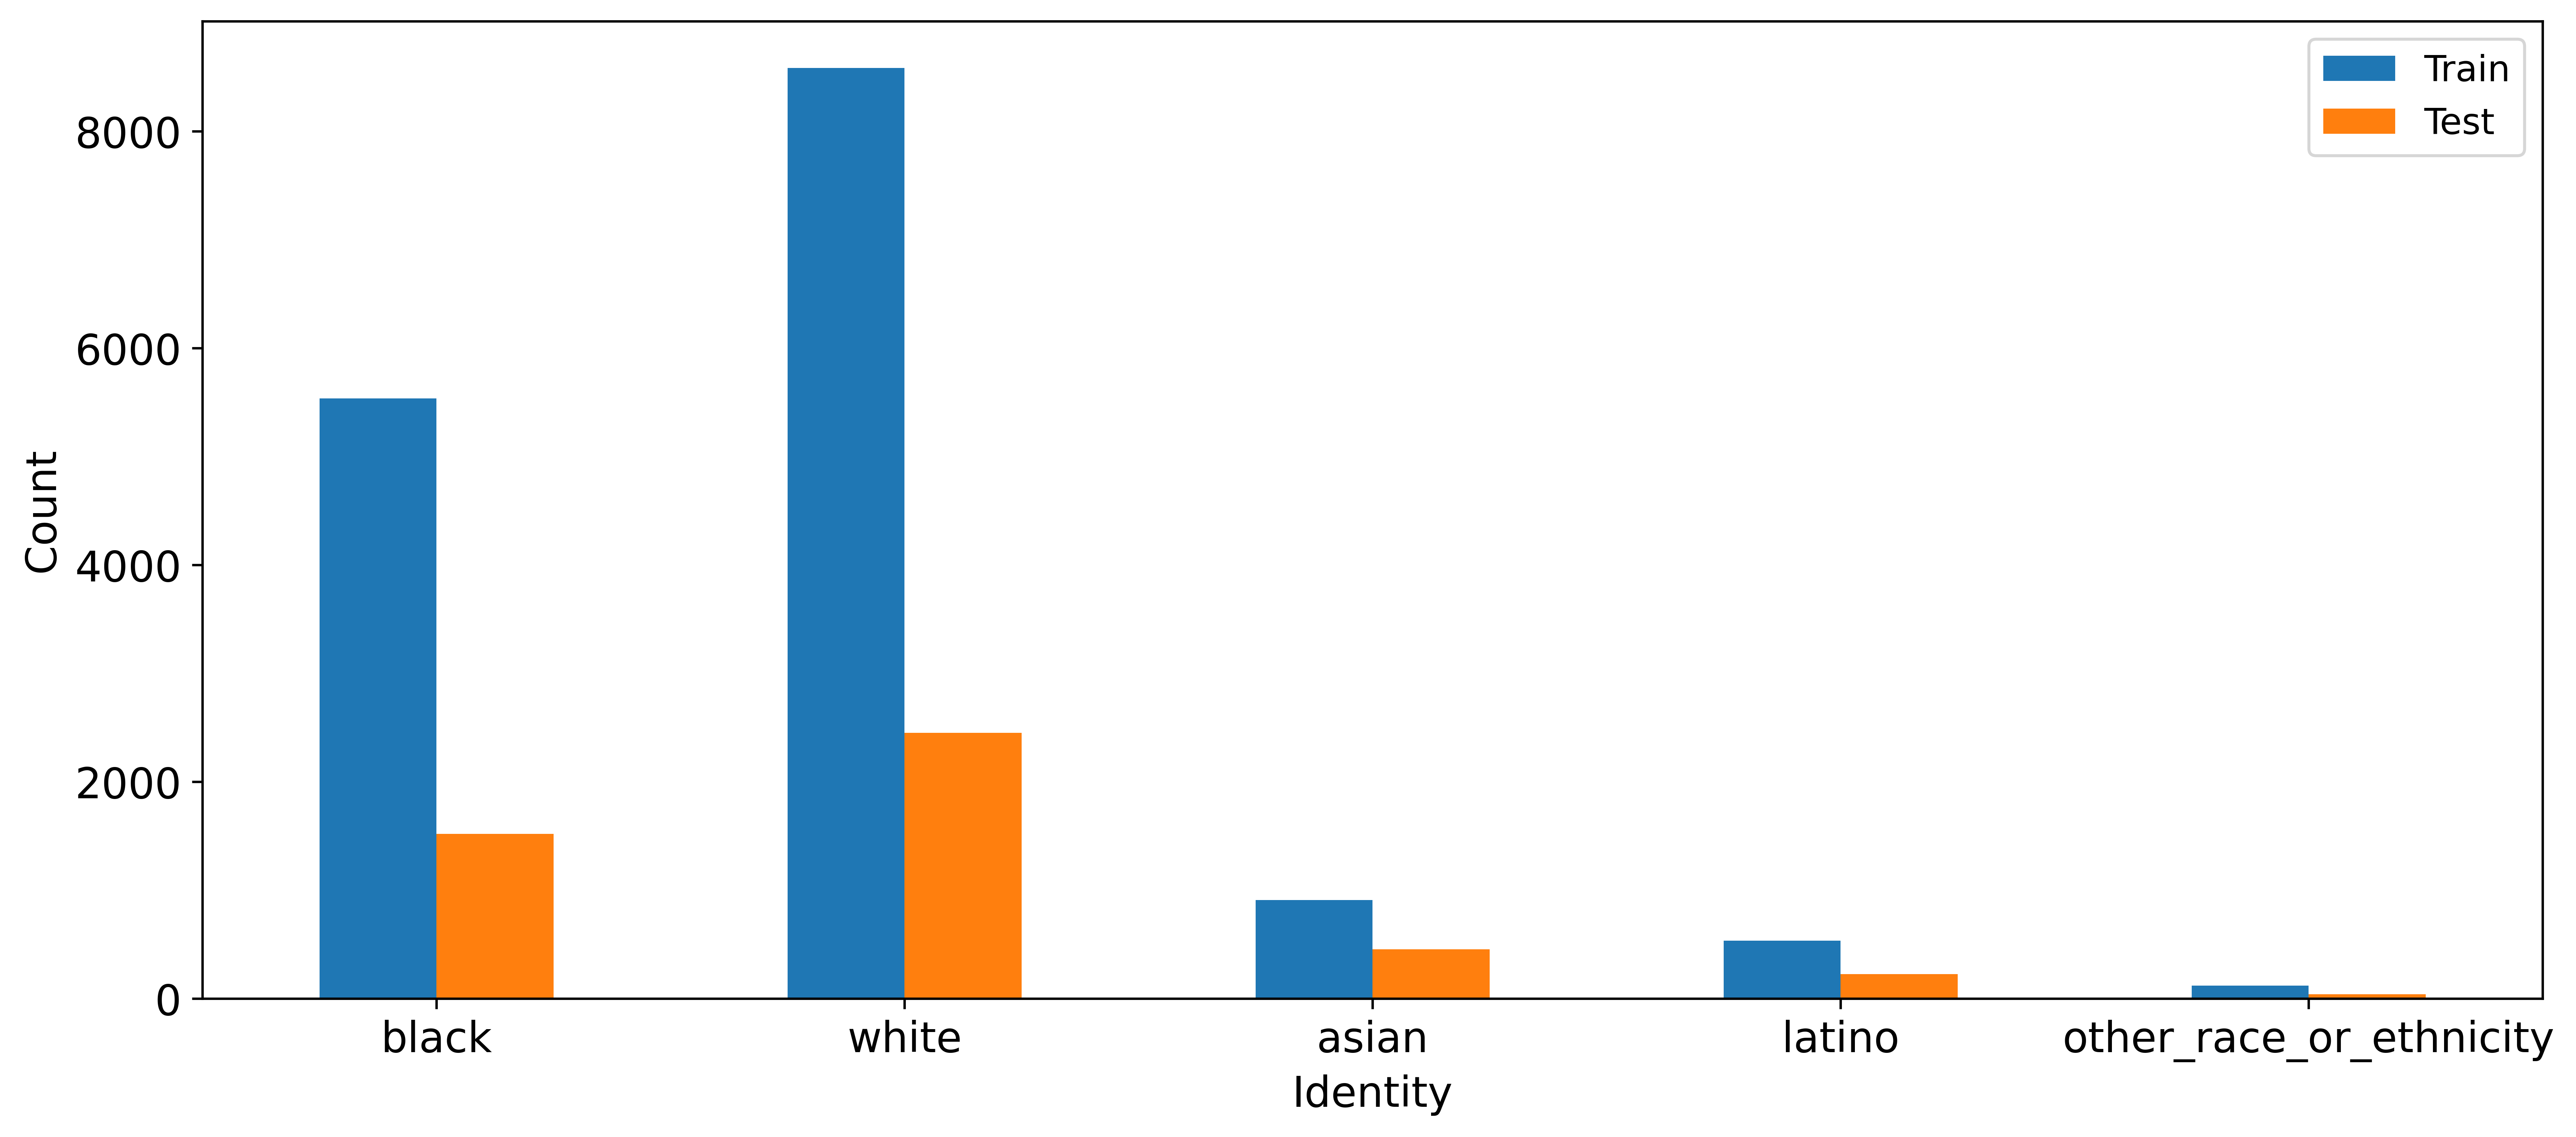

In [27]:
plot_metric(count_df, "Count", subgroup_type,metric='count')

## AUC

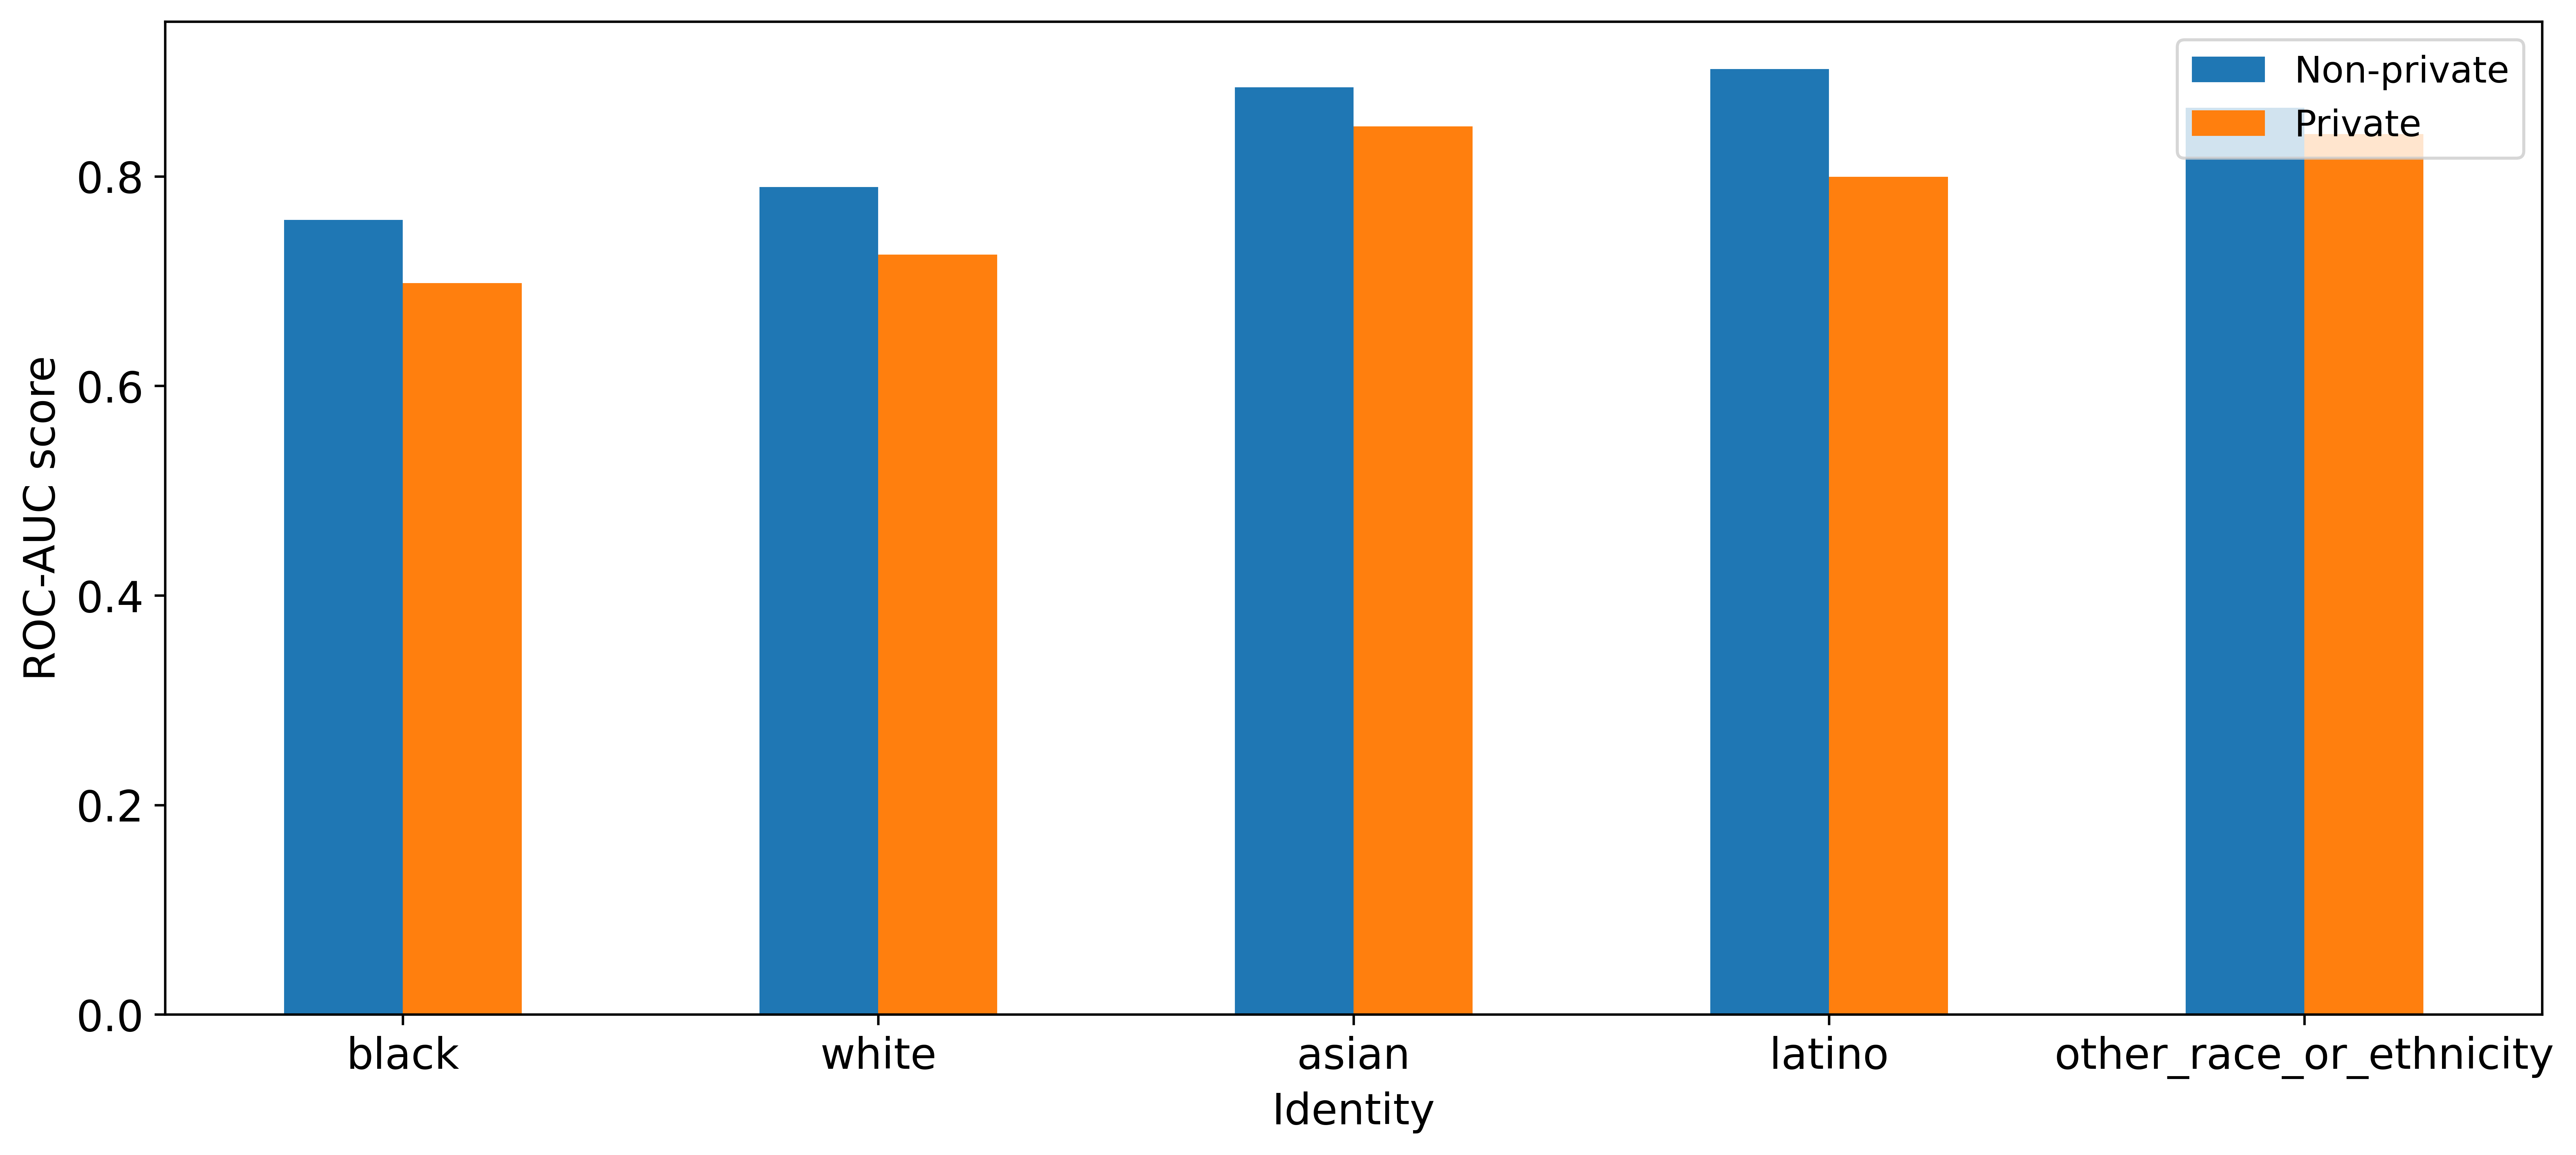

In [28]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[SUBGROUP_AUC],
        'Private': test_dp_bias_metrics_df[SUBGROUP_AUC]
    }
)
plot_metric(plot_df, "ROC-AUC score", subgroup_type,metric='AUC')

## F1-score

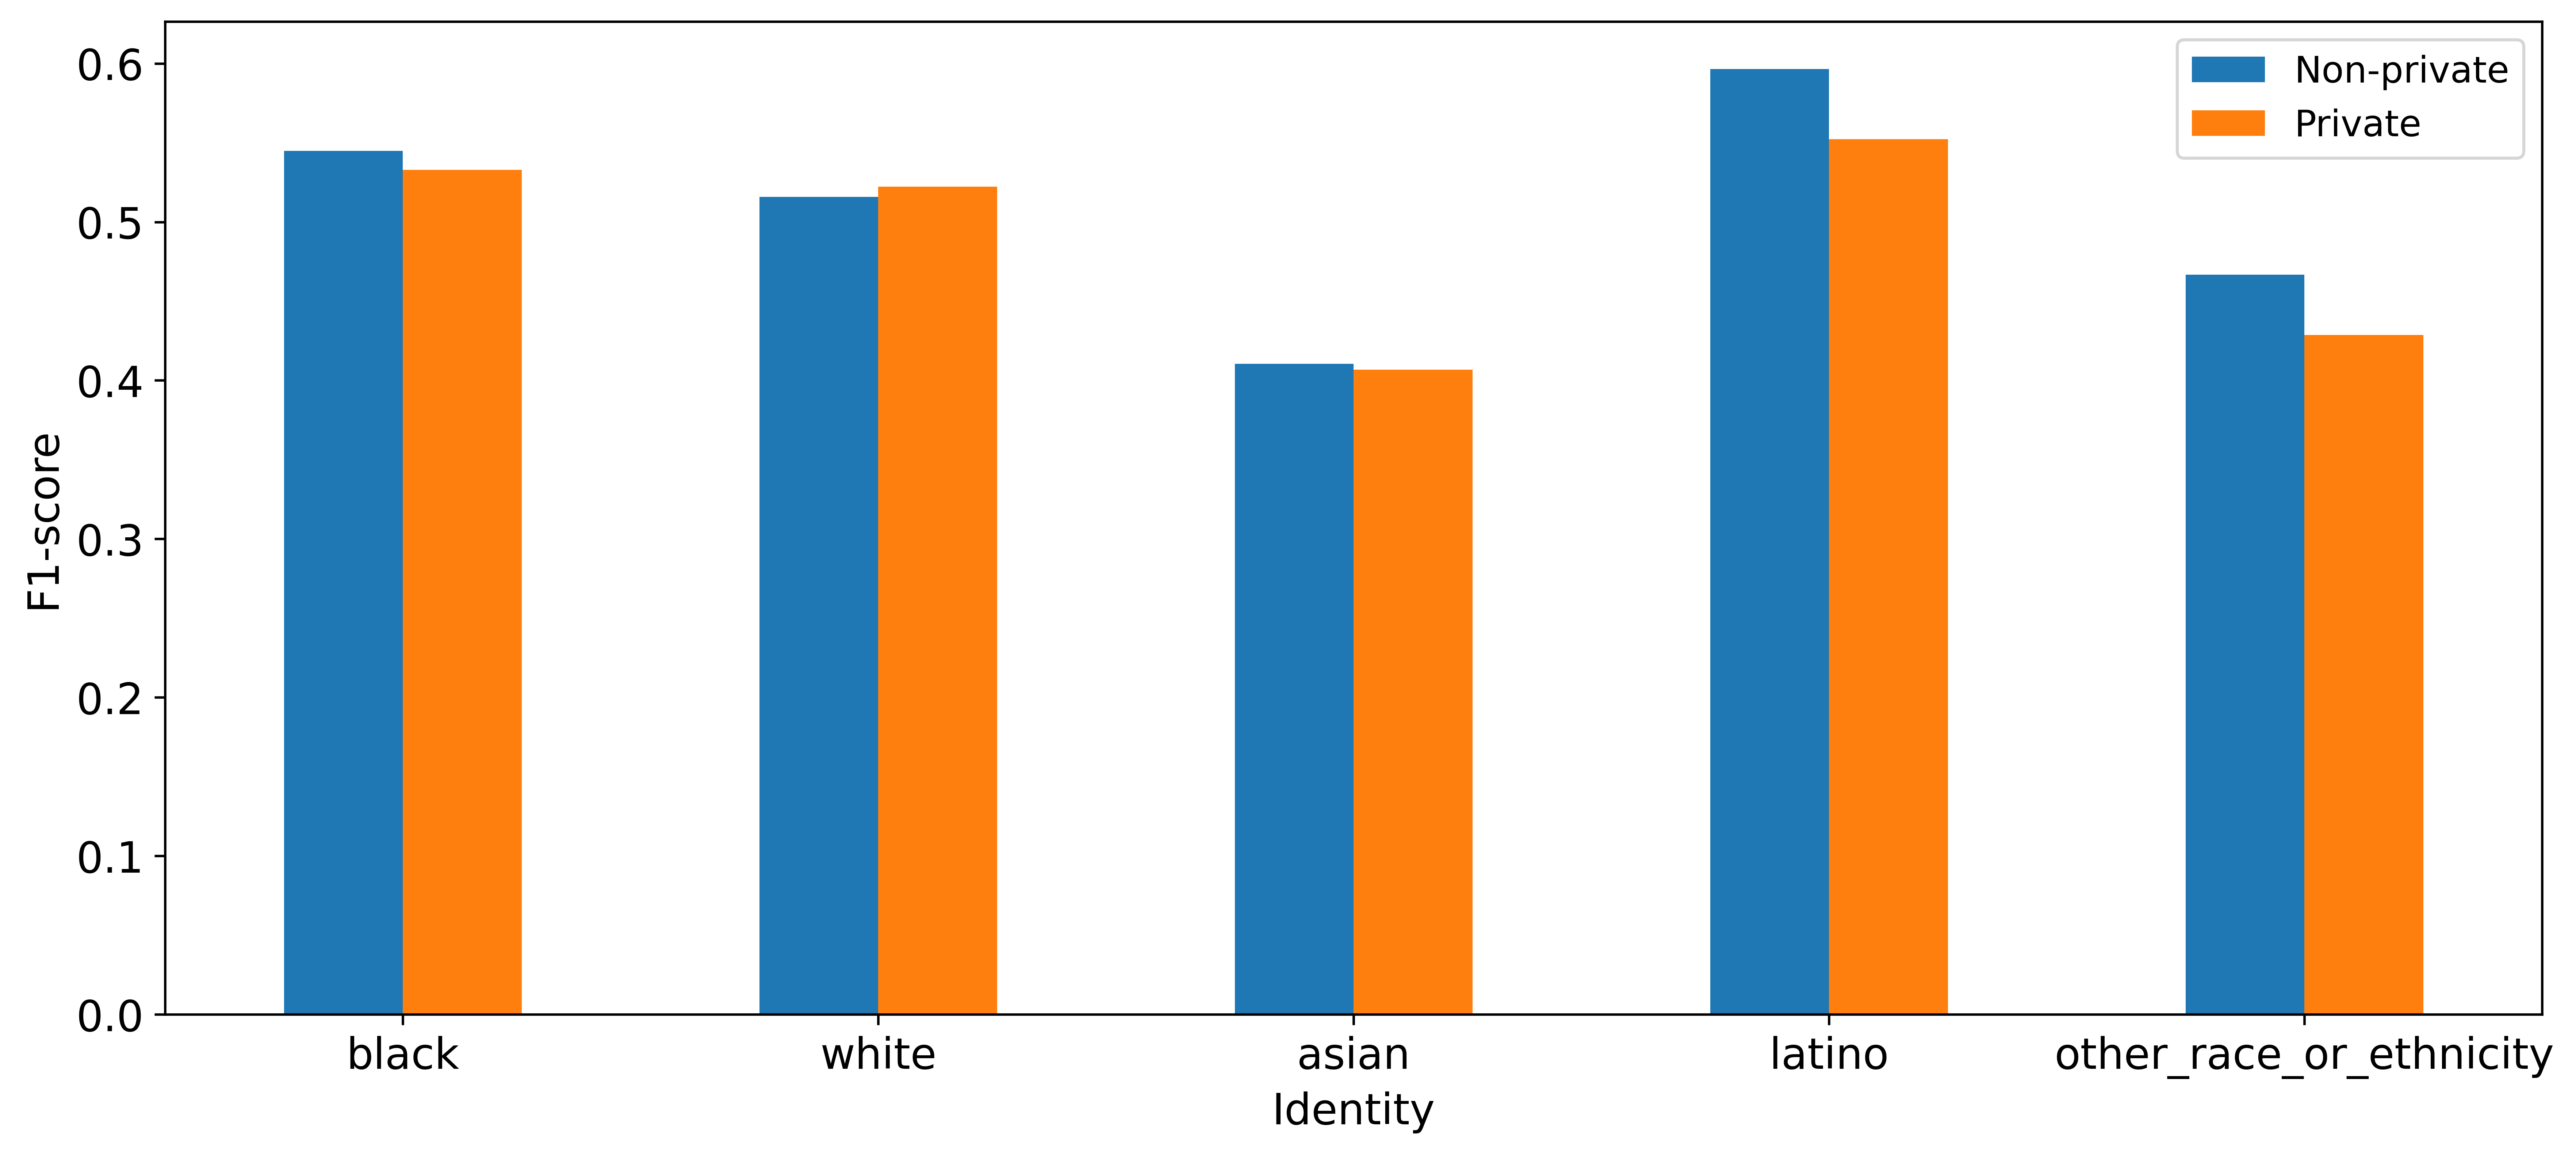

In [29]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[SUBGROUP_F1],
        'Private': test_dp_bias_metrics_df[SUBGROUP_F1]
    }
)

plot_metric(plot_df, "F1-score", subgroup_type,metric='F1')

## False Positive Rate

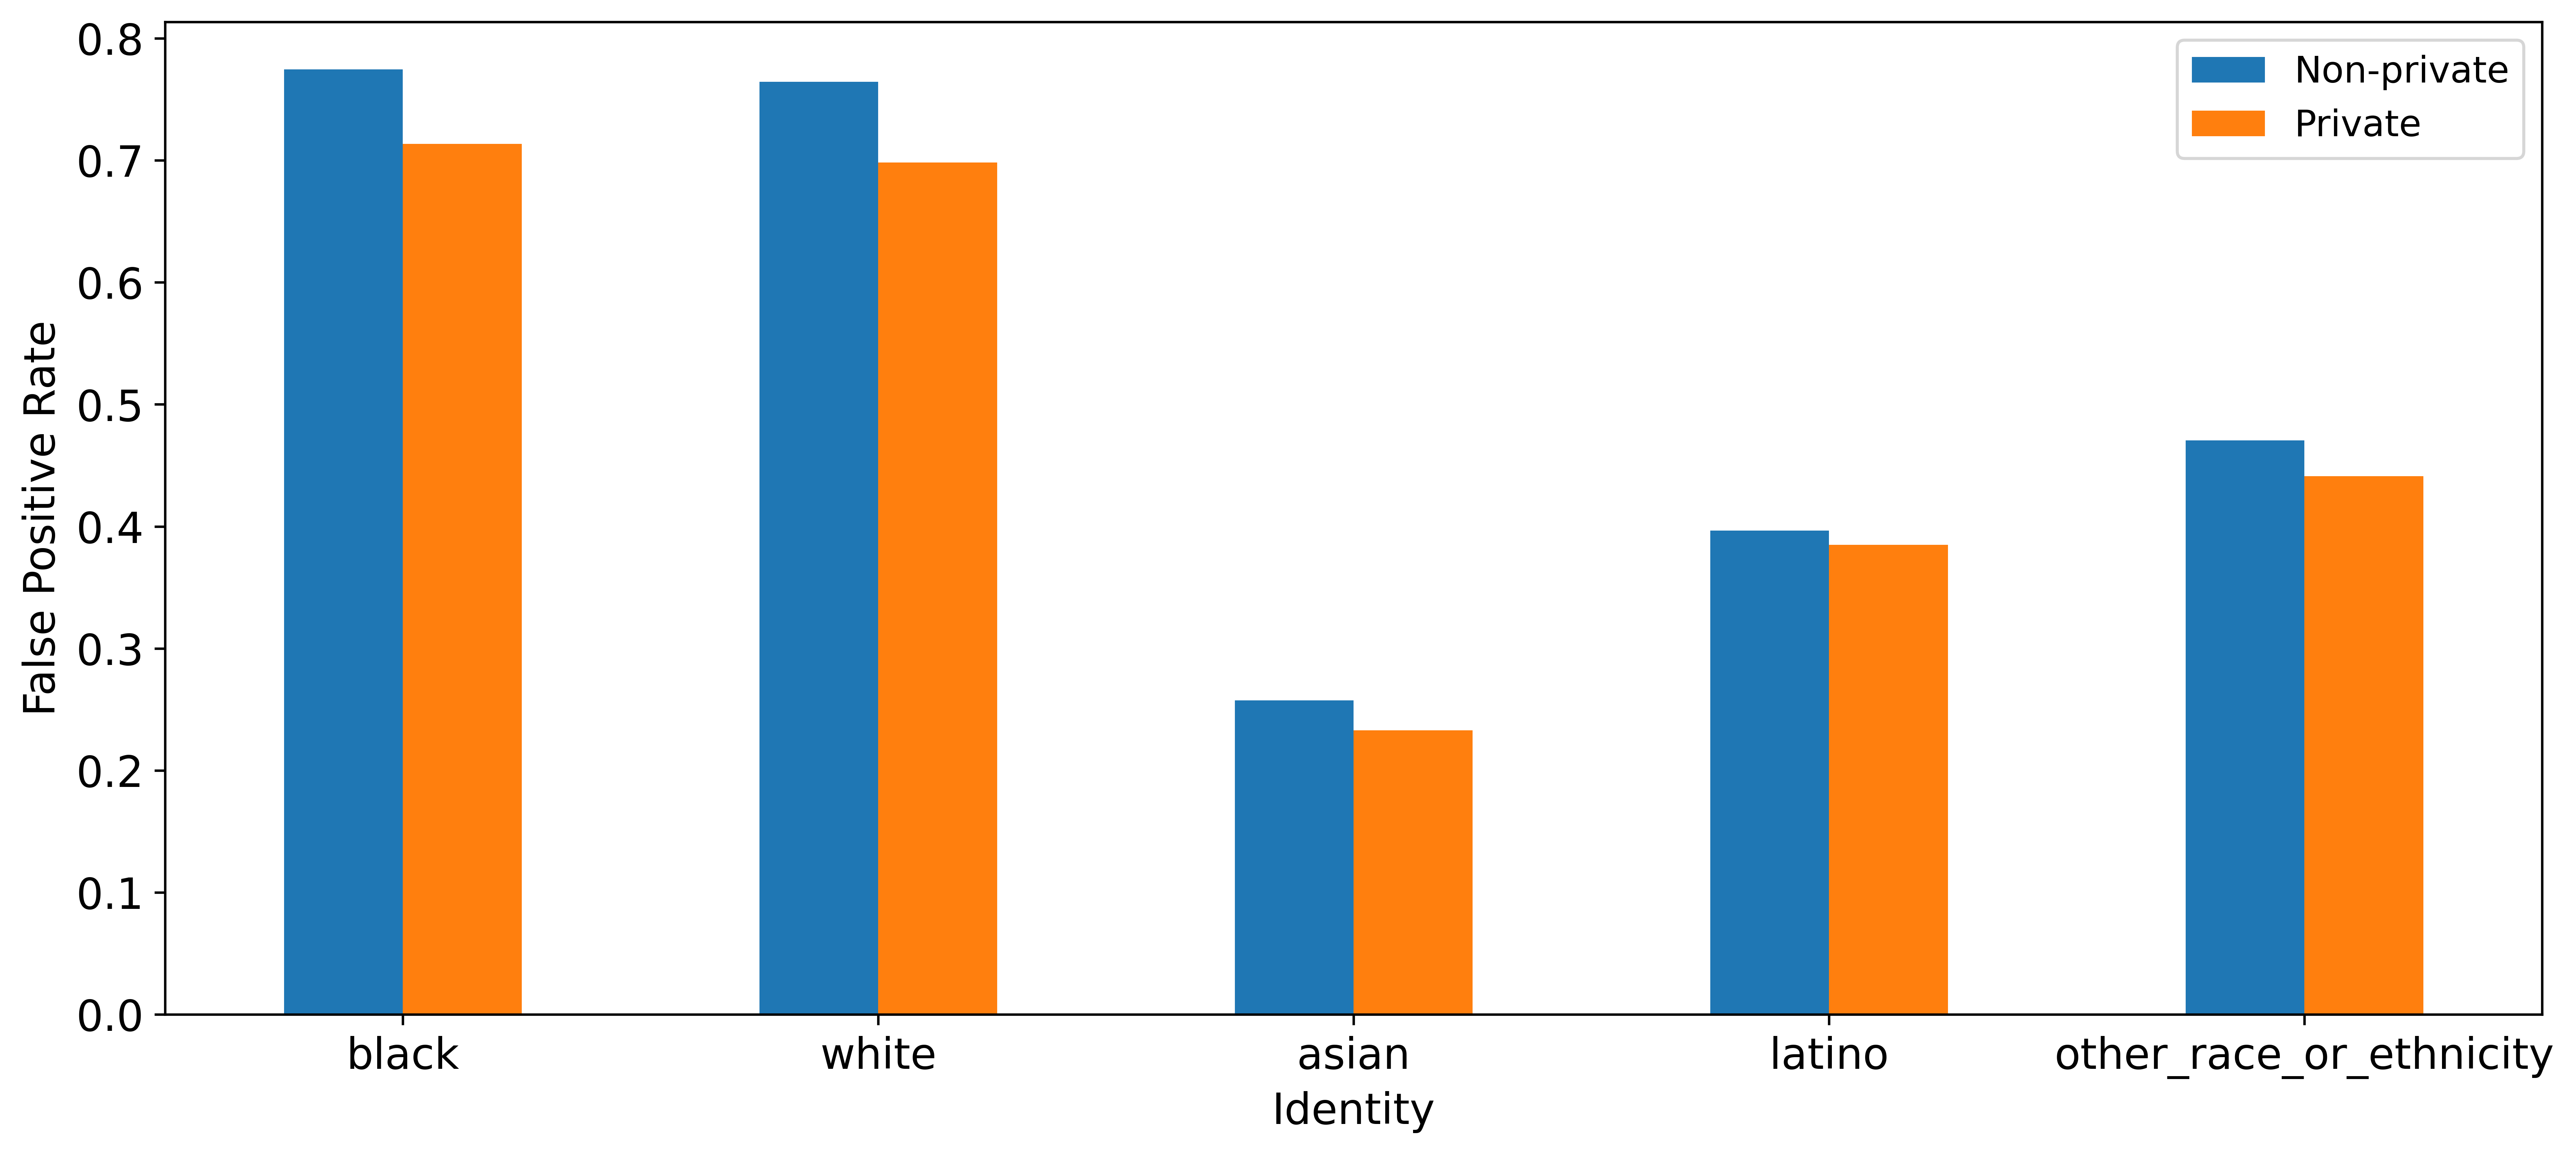

In [30]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[SUBGROUP_FPR],
        'Private': test_dp_bias_metrics_df[SUBGROUP_FPR]
    }
)

plot_metric(plot_df, "False Positive Rate", subgroup_type,metric='FPR')

## Accuracy

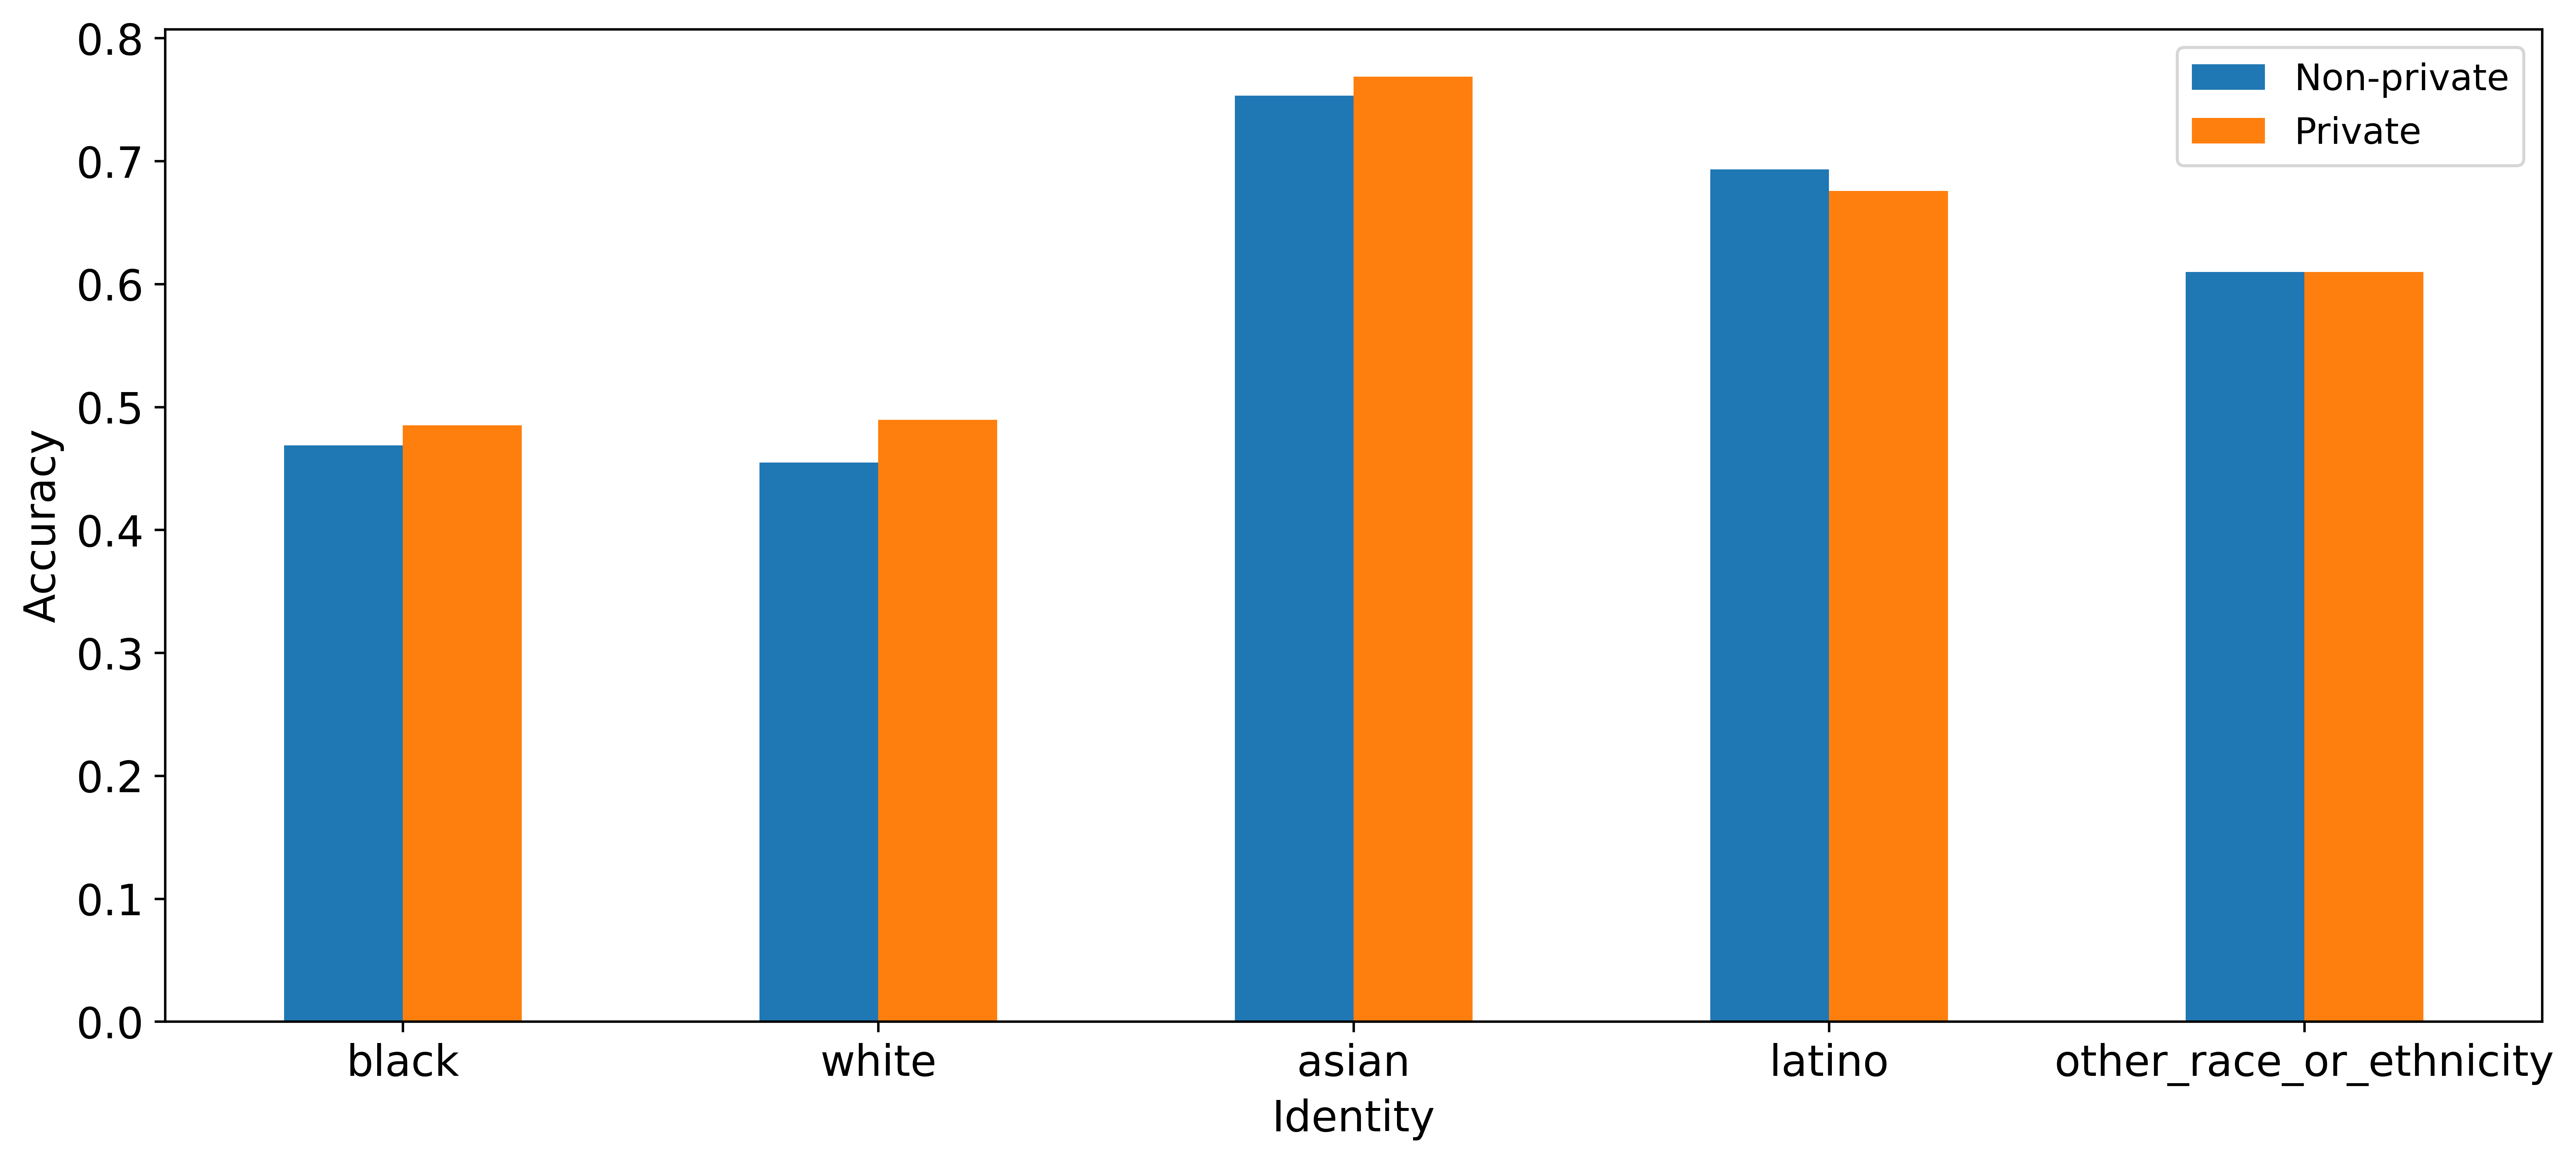

In [31]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[SUBGROUP_ACCURACY],
        'Private': test_dp_bias_metrics_df[SUBGROUP_ACCURACY]
    }
)
plot_metric(plot_df, "Accuracy", subgroup_type,metric='Accuracy')

## BPSN

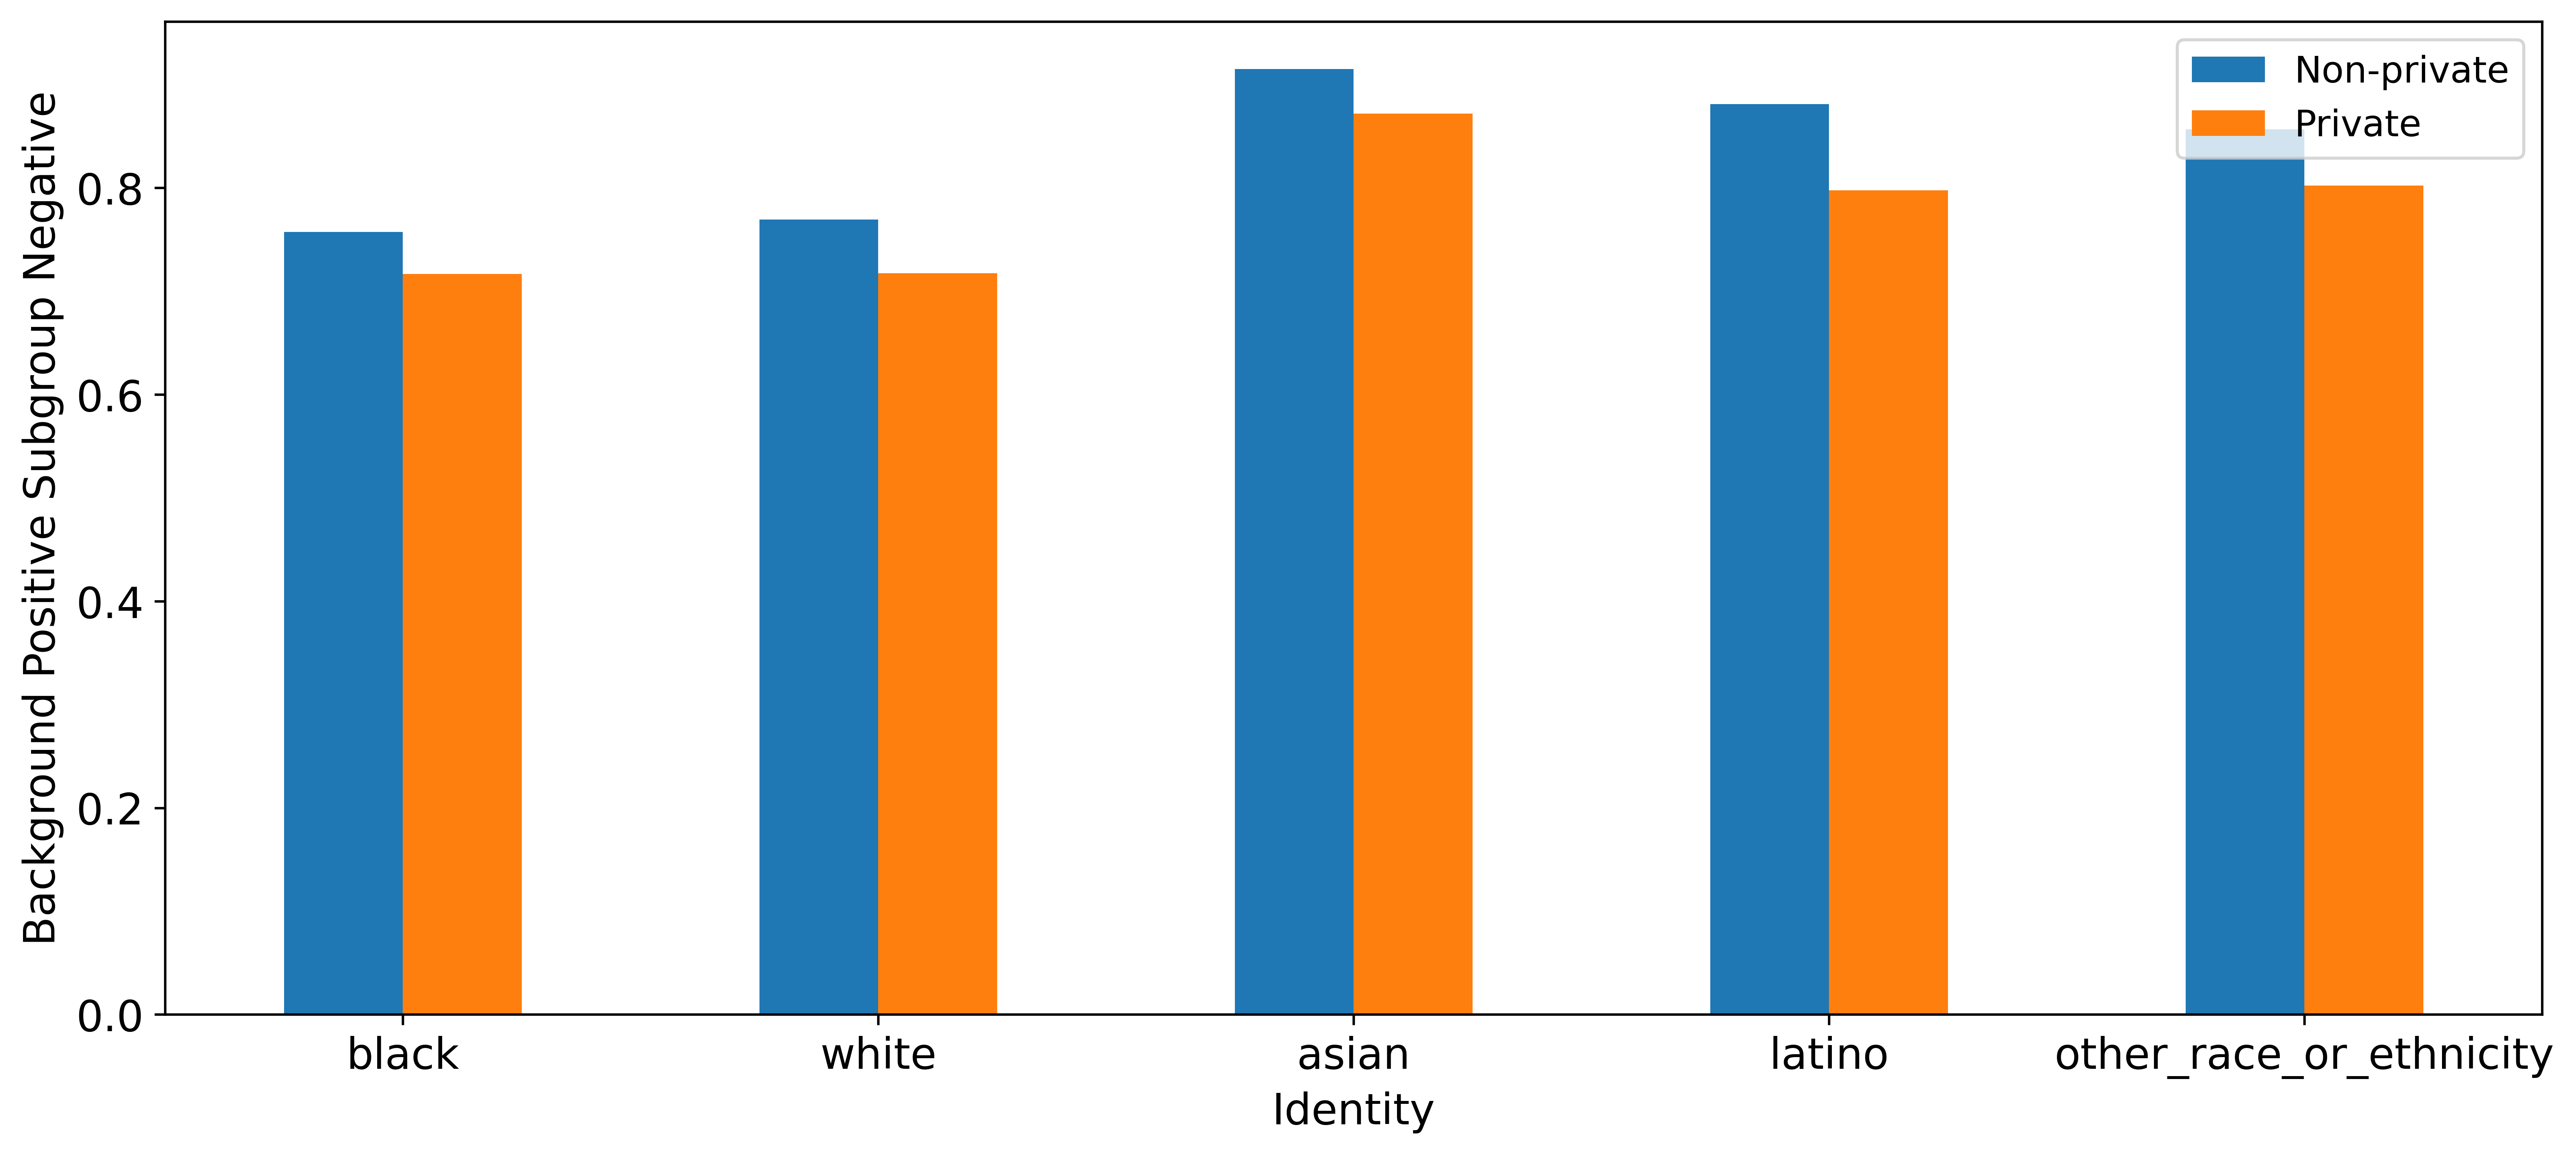

In [32]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[BPSN_AUC],
        'Private': test_dp_bias_metrics_df[BPSN_AUC]
    }
)
plot_metric(plot_df, "Background Positive Subgroup Negative", subgroup_type,metric='BPSN')

## BNSP

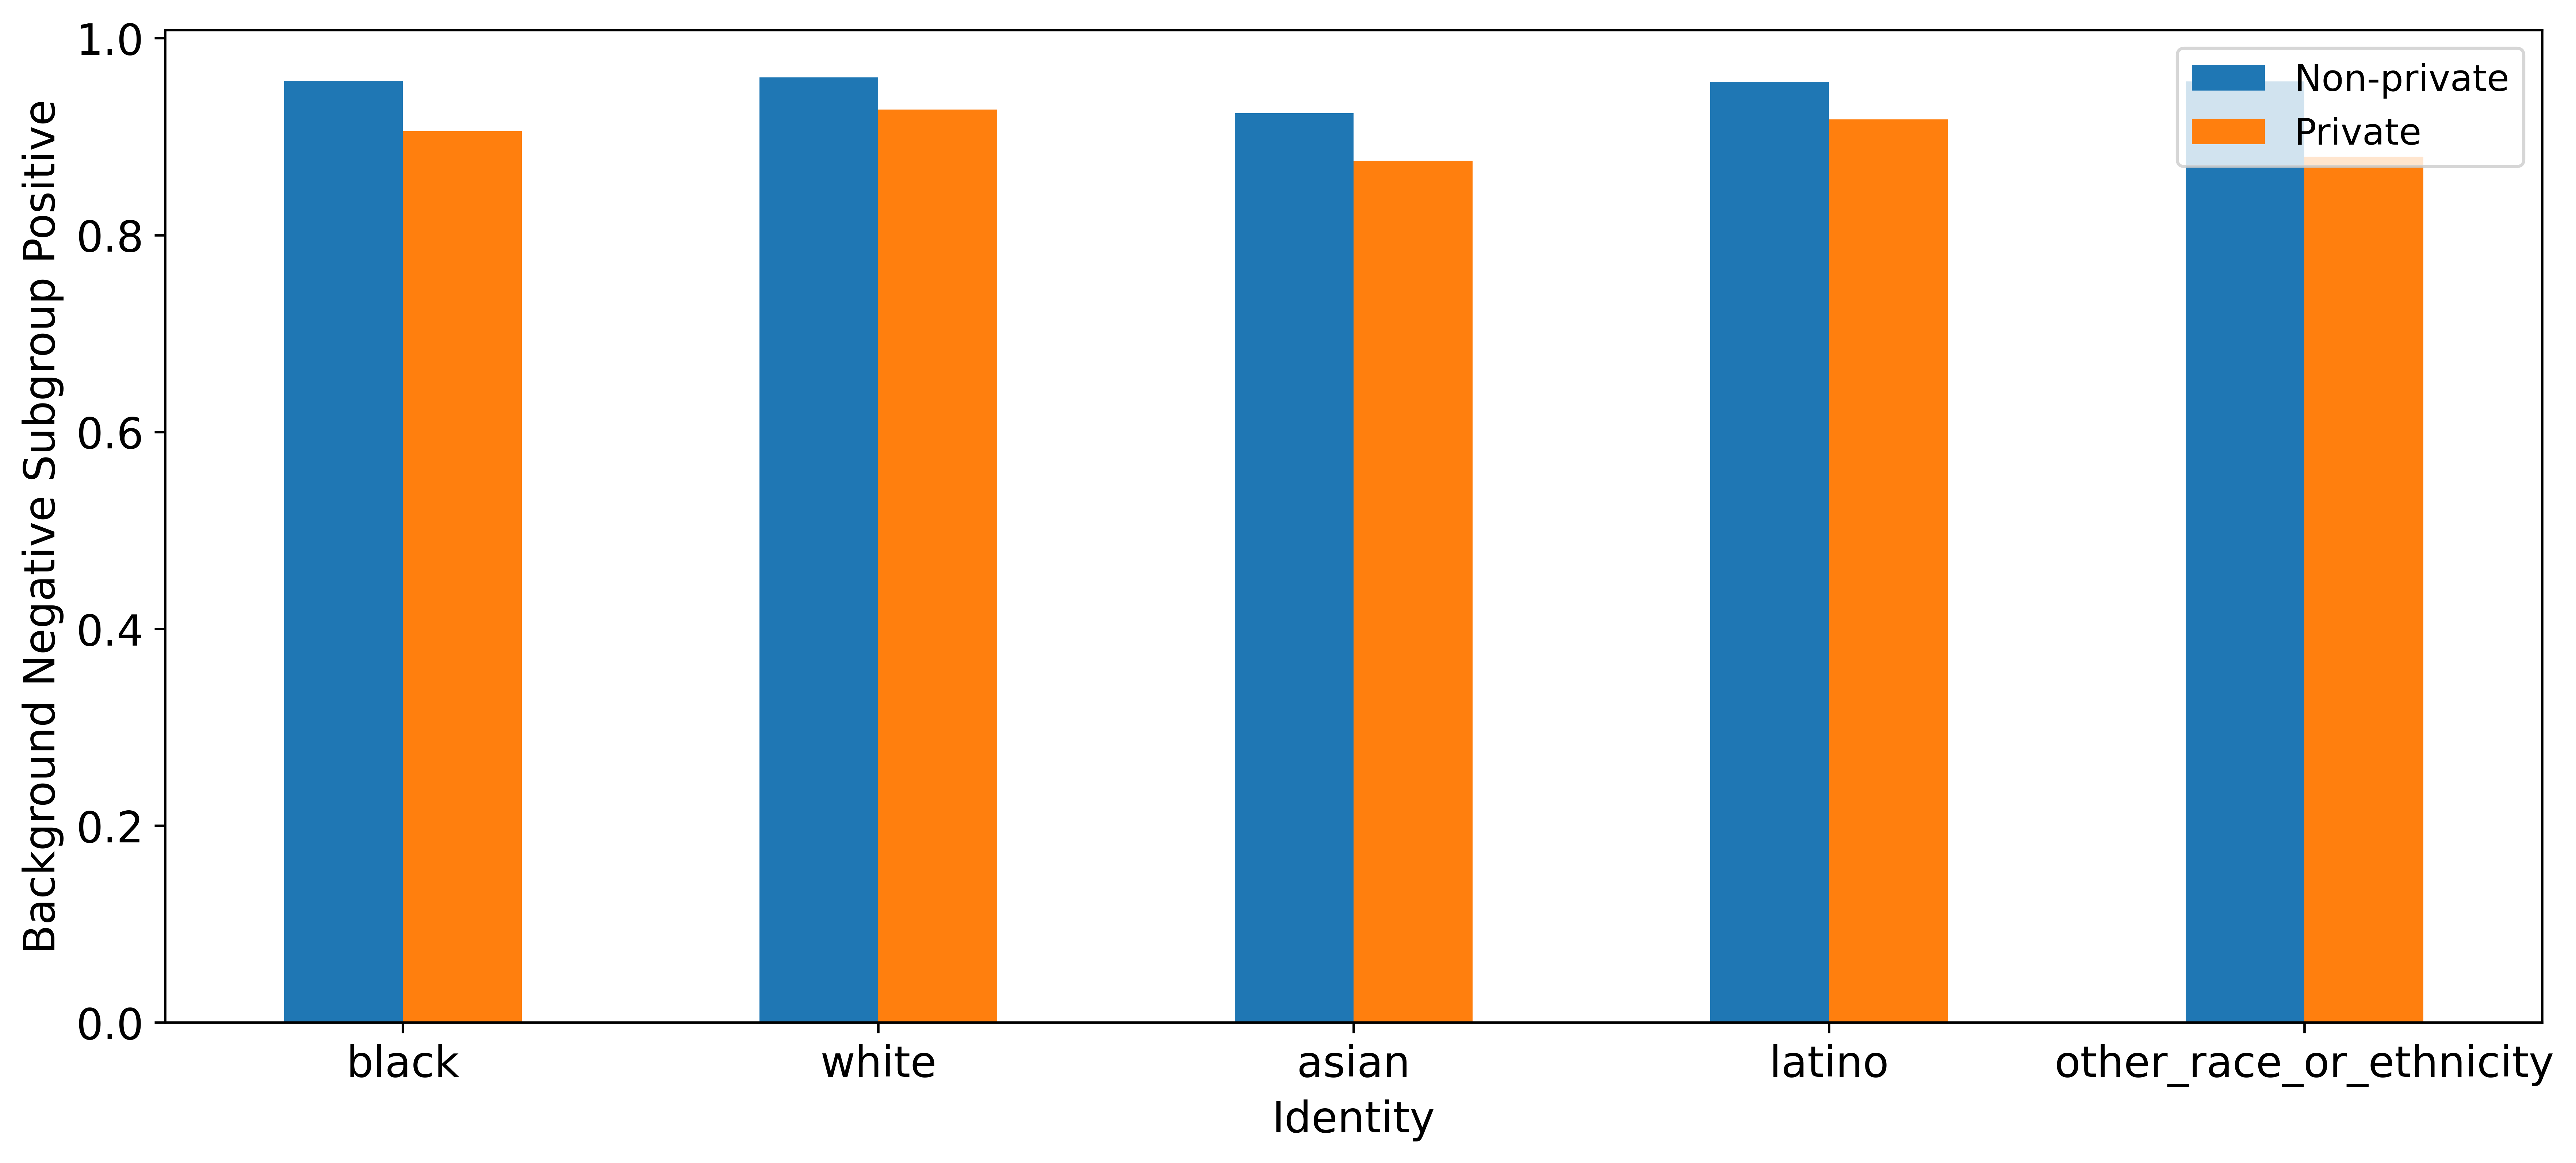

In [33]:
plot_df = pd.DataFrame(
    {
        'Identity':identity_columns,
        'Non-private': test_bias_metrics_df[BNSP_AUC],
        'Private': test_dp_bias_metrics_df[BNSP_AUC]
    }
)
plot_metric(plot_df, "Background Negative Subgroup Positive", subgroup_type,metric='BNSP_AUC')